# Baseline Model

**Table of Contents**
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


### Model Choice
A Convolutional Neural Network (CNN) is an ideal baseline model for classifying 50 types of phytoplankton images, as it excels in capturing the subtle variances in shape, size, and texture that are crucial for distinguishing between different phytoplankton types. With its robustness to image variations and effectiveness in complex multi-class tasks, a CNN is highly suitable for this purpose. Moreover, its scalability and the potential for transfer learning add to its practicality in handling diverse datasets. Importantly, a CNN serves as an excellent starting point for model optimization, where further improvements can be achieved by fine-tuning hyperparameters and experimenting with various preprocessing techniques, allowing for tailored enhancements to suit specific dataset characteristics.

In [11]:
from google.colab import files, drive
import zipfile
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Activation, Flatten, MaxPooling2D, Conv2D
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2

In [4]:
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/ML_Tensorflow/phytoplankton_labeled.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

data_dir = '/content/dataset/labeled_20201020'

Mounted at /content/drive


In [6]:
file_path = '/content/dataset/SYKE_plankton_IFCB_2022_info.pdf'

# Check if the file exists and then remove it
if os.path.exists(file_path):
    os.remove(file_path)
    print("File removed successfully")
else:
    print("The file does not exist")

File removed successfully


In [7]:
# Split the Data into train, validation, and test sets; get all image paths and their corresponding labels
image_paths = []
labels = []
for class_dir in os.listdir(data_dir):
    class_dir_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_dir_path):
        for image in os.listdir(class_dir_path):
            image_paths.append(os.path.join(class_dir_path, image))
            labels.append(class_dir)

# Convert labels to numerical format
labels = np.array(labels)
label_to_index = dict((name, index) for index, name in enumerate(np.unique(labels)))
labels = np.array([label_to_index[label] for label in labels])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=42)

# Print dataset split summary
print(f"Total images: {len(image_paths)}")
print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

Total images: 63074
Training set: 44277 images
Validation set: 12489 images
Test set: 6308 images


### Feature Selection

In the context of using a Convolutional Neural Network (CNN) for classifying images of phytoplankton, "feature selection" takes on a different meaning compared to traditional machine learning models. Unlike models where you manually select features from a dataset, CNNs handle feature extraction and selection internally through their layers.

Training Data Examples:
Example 1:
Image batch shape: (64, 160, 160, 3)
Label batch shape: (64, 50)


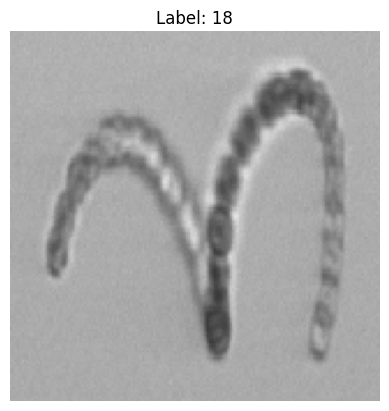

In [17]:
# Data Preprocessing and Augmentation setup
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data in Batches
def data_generator(image_paths, labels, batch_size, datagen):
    while True:
        for start in range(0, len(image_paths), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_paths))
            for img_path, label in zip(image_paths[start:end], labels[start:end]):
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(160, 160))
                img = tf.keras.preprocessing.image.img_to_array(img)
                x_batch.append(img)
                y_batch.append(label)
            x_batch = np.array(x_batch)
            y_batch = tf.keras.utils.to_categorical(y_batch, num_classes=50)
            yield datagen.flow(x_batch, y_batch, batch_size=batch_size).next()

# Define batch size
batch_size = 64

# Create data generators
train_generator = data_generator(X_train, y_train, batch_size, train_datagen)
val_generator = data_generator(X_val, y_val, batch_size, val_datagen)
test_generator = data_generator(X_test, y_test, batch_size, test_datagen)

# Function to print data format and display images
def print_and_display_data_examples(generator, num_examples=1, num_images=1):
    for i in range(num_examples):
        # Get the next batch of images and labels
        x_batch, y_batch = next(generator)
        print(f'Example {i+1}:')
        print(f'Image batch shape: {x_batch.shape}')
        print(f'Label batch shape: {y_batch.shape}')

        # Display the first 'num_images' images in the batch
        for j in range(num_images):
            plt.imshow(x_batch[j])
            plt.title(f'Label: {np.argmax(y_batch[j])}')
            plt.axis('off')  # Hide the axis
            plt.show()  # Show one image at a time

# Print and display examples from the training data generator
print('Training Data Examples:')
print_and_display_data_examples(train_generator)

### Implementation

This CNN model, with its multiple convolutional and pooling layers followed by fully connected layers, is designed to effectively capture the hierarchical features in the phytoplankton images, making it suitable for the classification task at hand. The use of ReLU and softmax activations, along with the adam optimizer and categorical crossentropy loss, aligns well with the needs of a complex image classification challenge.

In [18]:
num_classes = 50

# Choosing base model trained on imagenet (extracting weights etc.)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

for layer in base_model.layers:
    layer.trainable = False

# Define the custom layers to add on top of MobileNetV2
custom_layers = [
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(96, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(32),
    Activation('relu'),
    Dense(num_classes),
    Activation('softmax')
]

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_3 (Dense)             (None, 50)                51250     
                                                                 
Total params: 3620978 (13.81 MB)
Trainable params: 1362994 (5.20 MB)
Non-trainable params: 2257984 (8.61 MB)
________________

In [19]:
epochs = 2

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size
)

Epoch 1/2
691/691 [==============================] - 1443s 2s/step - loss: 0.3479 - accuracy: 0.8986 - val_loss: 0.2065 - val_accuracy: 0.9368
Epoch 2/2
691/691 [==============================] - 1287s 2s/step - loss: 0.1658 - accuracy: 0.9468 - val_loss: 0.1871 - val_accuracy: 0.9429


### Evaluation

1. Accuracy: This metric gives you a straightforward indication of the overall correctness of the model by showing the proportion of correct predictions out of all predictions. It's a useful initial indicator to see how well the model performs across all classes.

2. Confusion Matrix: This tool is particularly valuable in multi-class classification problems like your 50 phytoplankton types. It not only shows the overall performance but also breaks it down into each class, revealing how the model confuses between different types of phytoplankton. It can highlight if the model is particularly good or bad at classifying certain classes, which is critical information for fine-tuning.

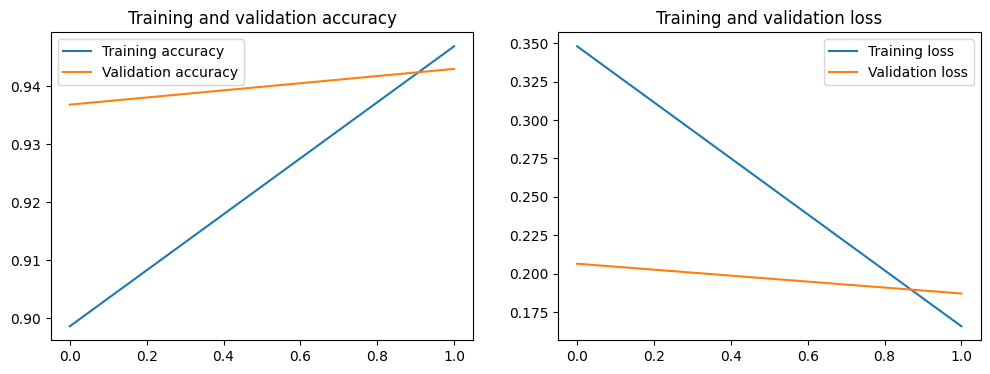

In [22]:
# Generate plots for data visualization
def plot_training_history(hhistory):
    acc = hhistory.history['accuracy']
    val_acc = hhistory.history['val_accuracy']
    loss = hhistory.history['loss']
    val_loss = hhistory.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(hhistory)

196/196 [==============================] - 286s 1s/step


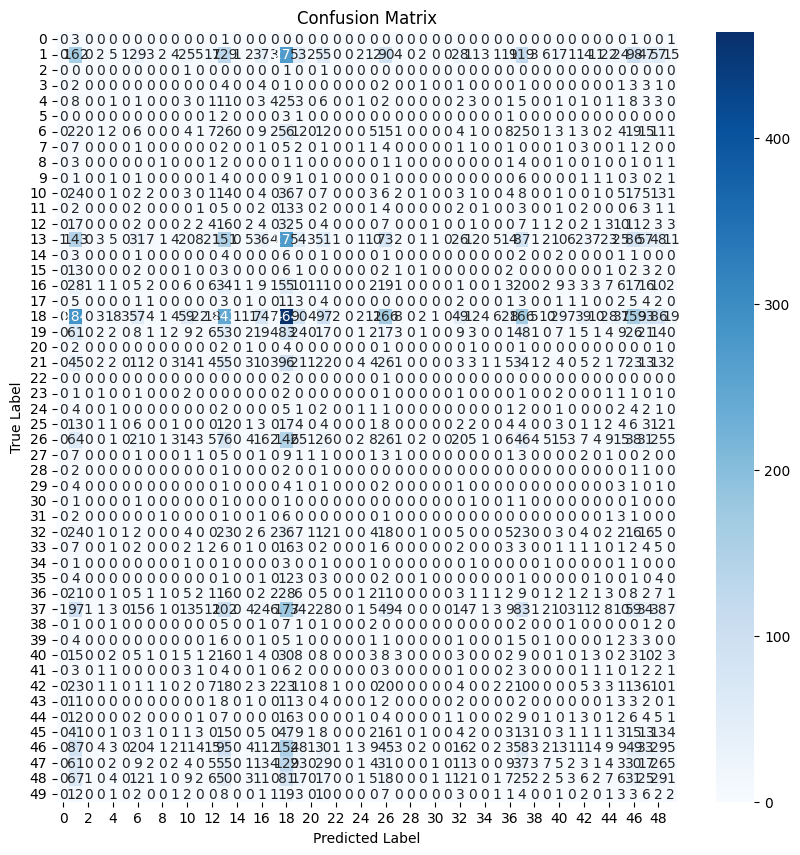

In [29]:
# Predict the labels for the test set
predictions = model.predict(test_generator, steps=np.math.ceil(len(X_test)/batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# and that it is a 1D array with the class indices as integers
true_classes = y_test

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [30]:
# Calculate the percentage of correct predictions for each class
correct_predictions = np.diag(cm)
total_predictions = np.sum(cm, axis=1)
class_accuracies = correct_predictions / total_predictions

# Sort classes by their accuracy
sorted_indices = np.argsort(class_accuracies)
sorted_accuracies = class_accuracies[sorted_indices]
sorted_classes = sorted_indices  # Assuming classes are labeled from 0 to n-1

# Sorted accuracies and class indices
for class_index, accuracy in zip(sorted_classes, sorted_accuracies):
    print(f"Class {class_index}: {accuracy * 100:.2f}%")


Class 0: 0.00%
Class 30: 0.00%
Class 31: 0.00%
Class 33: 0.00%
Class 23: 0.00%
Class 22: 0.00%
Class 34: 0.00%
Class 20: 0.00%
Class 35: 0.00%
Class 17: 0.00%
Class 38: 0.00%
Class 15: 0.00%
Class 28: 0.00%
Class 14: 0.00%
Class 41: 0.00%
Class 9: 0.00%
Class 43: 0.00%
Class 7: 0.00%
Class 5: 0.00%
Class 3: 0.00%
Class 2: 0.00%
Class 29: 0.00%
Class 40: 0.66%
Class 25: 0.85%
Class 4: 1.02%
Class 44: 1.20%
Class 45: 1.28%
Class 36: 1.29%
Class 10: 1.74%
Class 11: 1.82%
Class 49: 2.08%
Class 6: 2.15%
Class 32: 2.21%
Class 27: 2.38%
Class 42: 2.70%
Class 39: 2.70%
Class 12: 2.76%
Class 16: 3.02%
Class 47: 3.14%
Class 24: 3.23%
Class 26: 3.79%
Class 8: 4.76%
Class 21: 4.89%
Class 19: 5.11%
Class 48: 6.13%
Class 46: 6.21%
Class 37: 9.29%
Class 13: 11.17%
Class 1: 11.46%
Class 18: 18.99%
